# Modeling

This notebook contains all steps taken in the modeling phase of the data science pipeline for the Superstore Time Series project. This notebook does rely on helper files so if you want to run the code blocks in this notebook ensure that you have all the helper files in the same directory.

---

## The Required Imports

Everything we need to run the code blocks in this notebook are imported below. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn and sklearn installed on your computer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from prophet import Prophet

from sklearn.metrics import mean_squared_error

# from prepare import split_data
from wrangle import wrangle
from prepare import split_data
from evaluate import *
from model import *

Importing plotly failed. Interactive plots will not work.


---

## Acquire, Prepare, and Split the Data

Here we will acquire and prepare the data using the wrangle module. We'll then split each dataframe into train, validate, and test using the prepare module.

In [2]:
superstore, store_east, store_west, store_south, store_central, office_supplies, furniture, technology = wrangle()

Reading from .csv file.


In [3]:
# Here we'll resample into a less finely grained period to produce a more accurate forecast.

resample_period = 'Q'

# This is the periods that are used for producing the moving averages
periods = [1, 2, 4]

# Year size for previous cycle
year_size = 4

superstore = superstore.resample(resample_period).sum()

store_east = store_east.resample(resample_period).sum()
store_west = store_west.resample(resample_period).sum()
store_south = store_south.resample(resample_period).sum()
store_central = store_central.resample(resample_period).sum()

office_supplies = office_supplies.resample(resample_period).sum()
furniture = furniture.resample(resample_period).sum()
technology = technology.resample(resample_period).sum()

In [4]:
superstore_train, superstore_validate, superstore_test = split_data(superstore)

store_east_train, store_east_validate, store_east_test = split_data(store_east)
store_west_train, store_west_validate, store_west_test = split_data(store_west)
store_south_train, store_south_validate, store_south_test = split_data(store_south)
store_central_train, store_central_validate, store_central_test = split_data(store_central)

office_supplies_train, office_supplies_validate, office_supplies_test = split_data(office_supplies)
furniture_train, furniture_validate, furniture_test = split_data(furniture)
technology_train, technology_validate, technology_test = split_data(technology)

---

## Establishing a Baseline

Now we need to establish a baseline against which to compare the performance of our models. We'll use various simple forecasting strategies (last observed value, simple average, various moving averages) and pick the strategy with the lowest RMSE value to be our baseline.

### Last Observed Value

We'll start by creating a last observed value forecast.

In [5]:
# Calculate the last observed value.

last_observed_value = round(superstore_train.sales[-1], 2)
last_observed_value

30820.28

In [6]:
# Create a dataframe of predictions using the last observed value.

predictions = make_static_predictions('sales', last_observed_value, superstore_validate.index)
predictions.head()

,sales
order_date,
2016-03-31,30820.28
2016-06-30,30820.28
2016-09-30,30820.28
2016-12-31,30820.28


In [7]:
# Add the results to the eval_df.

eval_df = append_eval_df('Last Observed Value', 'sales', superstore_validate, predictions)
eval_df

,model_type,target,rmse
0,Last Observed Value,sales,8213.0


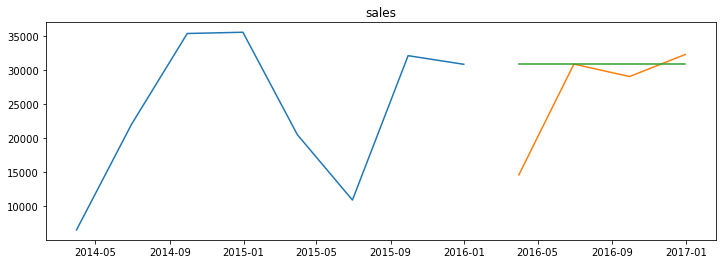

In [8]:
# Visualize the results.

plot_forecast('sales', superstore_train, superstore_validate, predictions)

### Simple Average

Now let's create a simple average forecast.

In [9]:
# Calculate the simple average.

simple_avg = round(superstore_train.sales.mean(), 2)
simple_avg

24196.74

In [10]:
# Create a predictions dataframe using the simple average.

predictions = make_static_predictions('sales', simple_avg, superstore_validate.index)
predictions.head()

,sales
order_date,
2016-03-31,24196.74
2016-06-30,24196.74
2016-09-30,24196.74
2016-12-31,24196.74


In [11]:
# Add the results to eval_df.

eval_df = append_eval_df('Simple Average', 'sales', superstore_validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Last Observed Value,sales,8213.0
1,Simple Average,sales,7509.0


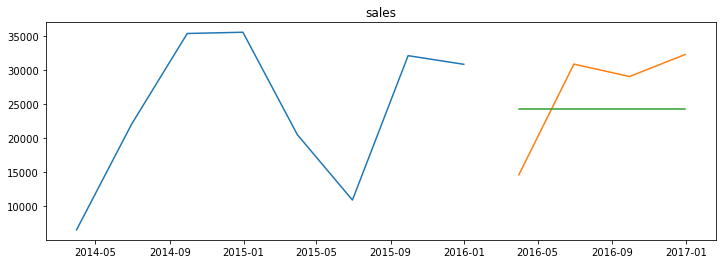

In [12]:
# Visualize the results.

plot_forecast('sales', superstore_train, superstore_validate, predictions)

### Moving Average

Now we'll create various moving average forecasts. We'll do the following moving averages: 1 month, 1 quarter, half year, and full year.

In [13]:
# For each period:
# - Calculate the moving average
# - Create the predictions dataframe
# - Add the results to eval_df
for period in periods:
    moving_avg = round(superstore_train.sales.rolling(period).mean()[-1], 2)
    predictions = make_static_predictions('sales', moving_avg, superstore_validate.index)
    eval_df = append_eval_df(f'Moving Average {period} Weeks', 'sales', superstore_validate, predictions, eval_df)
    
eval_df

,model_type,target,rmse
0,Last Observed Value,sales,8213.0
1,Simple Average,sales,7509.0
2,Moving Average 1 Weeks,sales,8213.0
3,Moving Average 2 Weeks,sales,8551.0
4,Moving Average 4 Weeks,sales,7744.0


### Results

For the overall total sales the simple average forecast provides the lowest RMSE value so this will be the baseline. We can determine this programmatically as well.

In [14]:
# Get the row with the minimum rmse value.

eval_df[eval_df.rmse == eval_df.rmse.min()]

,model_type,target,rmse
1,Simple Average,sales,7509.0


### Throw it in a Function

Finally, let's create a function that can determine the best baseline for us.

In [15]:
# def establish_baseline(train, validate):
#     forecast_values = {
#         'Last Observed Value' : round(train.sales[-1], 2),
#         'Simple Average' : round(train.sales.mean(), 2)
#     }

#     periods = [4, 12, 26, 52]
#     for period in periods:
#         forecast_values[f'Moving Average {period} Weeks'] = round(train.sales.rolling(period).mean()[-1], 2)

#     predictions = {}
#     for key, value in forecast_values.items():
#         predictions[key] = make_static_predictions('sales', value, validate.index)

#     eval_df = None
#     for key, prediction in predictions.items():
#         eval_df = append_eval_df(key, 'sales', validate, prediction, eval_df)

#     return eval_df[eval_df.rmse == eval_df.rmse.min()]

In [16]:
# Let's test it

# establish_baseline(superstore_train, superstore_validate)

In [17]:
# Now let's test it from the model.py file.

eval_df = establish_baseline(superstore_train, superstore_validate, periods)
eval_df

,model_type,target,rmse
1,Simple Average,sales,7509.0


---

## Creating Different Forecasting Models

Now that we have a baseline model we can try out some dynamic modeling strategies such as Holt's Linear Trend and FB Prophet.

### Holt's Linear Trend

Here we'll create a Holt model for forecasting sales.

In [18]:
# Create the model

model = Holt(superstore_train.sales, damped_trend = True)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [19]:
# Fit the model

model = model.fit()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [20]:
# Make predictions

predictions = model.predict(
    start = superstore_validate.index[0],
    end = superstore_validate.index[-1]
)
predictions.head()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2016-03-31    34310.196437
2016-06-30    37734.108164
2016-09-30    41123.780773
2016-12-31    44479.556657
Freq: Q-DEC, dtype: float64

In [21]:
# Make predictions a dataframe

predictions = pd.DataFrame(predictions, columns = ['sales'], index = predictions.index)
predictions.head()

,sales
2016-03-31,34310.196437
2016-06-30,37734.108164
2016-09-30,41123.780773
2016-12-31,44479.556657


In [22]:
eval_df = append_eval_df('Holt', 'sales', superstore_validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0
1,Holt,sales,13539.0


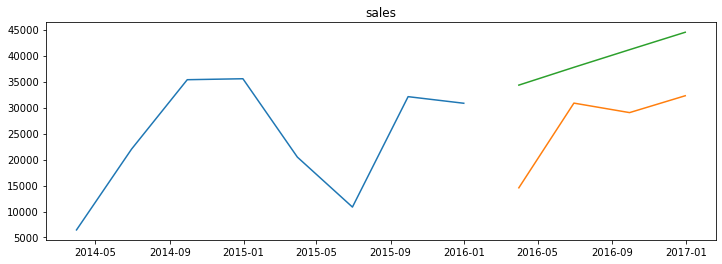

In [23]:
plot_forecast('sales', superstore_train, superstore_validate, predictions)

This model performs far worse than the baseline.

### FB Prophet

Now let's try a Prophet model.

In [24]:
# Create the model

model = Prophet()

In [25]:
# Fit the model

model.fit(pd.DataFrame({
    'ds' : superstore_train.index,
    'y' : superstore_train.sales
}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.


Initial log joint probability = -4.51096
Iteration  1. Log joint probability =    3.20768. Improved by 7.71863.
Iteration  2. Log joint probability =    5.41204. Improved by 2.20436.
Iteration  3. Log joint probability =    6.02108. Improved by 0.609046.
Iteration  4. Log joint probability =    6.12917. Improved by 0.10809.
Iteration  5. Log joint probability =     6.1552. Improved by 0.0260284.
Iteration  6. Log joint probability =    6.15964. Improved by 0.00443426.
Iteration  7. Log joint probability =    6.15966. Improved by 2.21161e-05.
Iteration  8. Log joint probability =    6.16281. Improved by 0.00315163.
Iteration  9. Log joint probability =    6.16308. Improved by 0.000266652.
Iteration 10. Log joint probability =    6.16394. Improved by 0.00086515.
Iteration 11. Log joint probability =    6.16419. Improved by 0.000245701.
Iteration 12. Log joint probability =    6.16432. Improved by 0.000128978.
Iteration 13. Log joint probability =    6.16466. Improved by 0.000343833.
Iter

In [26]:
# Make predictions

future = model.make_future_dataframe(365)
results = model.predict(future)
predictions = results[['ds', 'yhat']].set_index('ds')
predictions.columns = ['sales']
predictions = predictions.resample(resample_period).mean()
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2014-03-31 to 2016-12-31
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


In [27]:
predictions.loc['2016'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4 entries, 2016-03-31 to 2016-12-31
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   4 non-null      float64
dtypes: float64(1)
memory usage: 64.0 bytes


In [28]:
eval_df = append_eval_df('Prophet', 'sales', superstore_validate, predictions.loc['2016'], eval_df)
eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0
1,Holt,sales,13539.0
2,Prophet,sales,8472.0


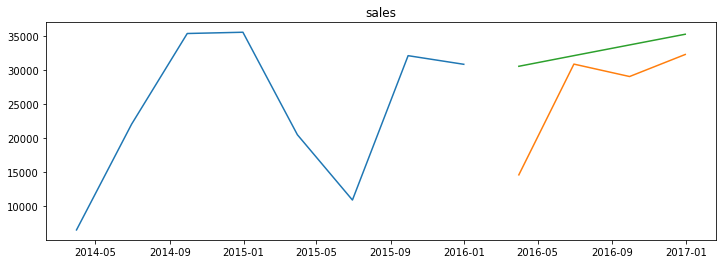

In [29]:
plot_forecast('sales', superstore_train, superstore_validate, predictions.loc['2016'])

Prophet also does not beat the baseline. We will likely need to narrow down the data by some category that will provide clearer insights into the sales trends. Without any seasonality in the data it's difficult to create an accurate model that does more than forecast average sales figures.

### Previous Cycle

Let's try one more strategy and use the previous cycle to predict the next one.

In [30]:
predictions = superstore_train.loc['2015'] + superstore_train.diff(year_size).mean()
predictions.index = superstore_validate.index

In [31]:
eval_df = append_eval_df('Previous Cycle', 'sales', superstore_validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0
1,Holt,sales,13539.0
2,Prophet,sales,8472.0
3,Previous Cycle,sales,11007.0


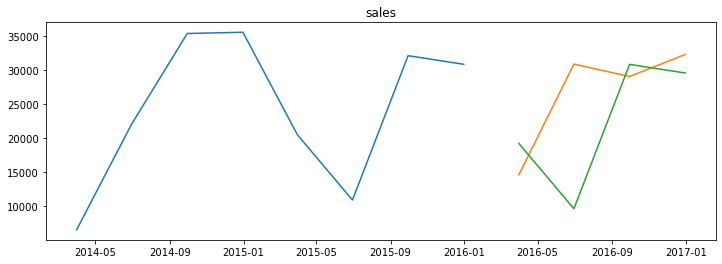

In [32]:
plot_forecast('sales', superstore_train, superstore_validate, predictions)

---

## Ensemble Model: A Model Per Region

In exploration we noticed that there is a little more seasonality when filtered by region. So here we will try to build an ensemble model where we have a sales forecast for each region and then combine the results to make a total sales forecast.

### Simple Average

Since the simple average provided the best results for the total sales model we'll create a simple average model here as well.

In [33]:
# Here we are using the model module to create an ensemble model for us.
# This will create simple average models for each region and then combine the results.

predictions = create_ensemble_predictions(
    [store_east_train, store_west_train, store_central_train, store_south_train],
    [store_east_validate, store_west_validate, store_central_validate, store_south_validate],
    'sales',
    simple_average_model
)
predictions.head()

,sales
order_date,
2016-03-31,24196.742338
2016-06-30,24196.742338
2016-09-30,24196.742338
2016-12-31,24196.742338


In [34]:
region_eval_df = append_eval_df('Simple Average', 'sales', superstore_validate, predictions)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0


### Holt's Linear Trend

Now let's try a Holt ensemble model.

In [35]:
# Here we are using the model module to create an ensemble model for us.
# This will create Holt's linear trend models for each region and then combine the results.

predictions = create_ensemble_predictions(
    [store_east_train, store_west_train, store_central_train, store_south_train],
    [store_east_validate, store_west_validate, store_central_validate, store_south_validate],
    'sales',
    holt_model
)
predictions.head()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,sales
2016-03-31,39913.416209
2016-06-30,45485.540436
2016-09-30,51001.943065
2016-12-31,56463.181316


In [36]:
region_eval_df = append_eval_df('Holt', 'sales', superstore_validate, predictions, region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0
1,Holt,sales,21942.0


### FB Prophet

Next, an ensemble model using Prophet.

In [37]:
# Here we are using the model module to create an ensemble model for us.
# This will create Prophet models for each region and then combine the results.

predictions = create_ensemble_predictions(
    [store_east_train, store_west_train, store_central_train, store_south_train],
    [store_east_validate, store_west_validate, store_central_validate, store_south_validate],
    'sales',
    prophet_model
)
predictions.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.



Initial log joint probability = -4.31401
Iteration  1. Log joint probability =    4.07672. Improved by 8.39073.
Iteration  2. Log joint probability =    7.88481. Improved by 3.8081.
Iteration  3. Log joint probability =    8.78012. Improved by 0.895309.
Iteration  4. Log joint probability =    8.80203. Improved by 0.0219081.
Iteration  5. Log joint probability =    8.80432. Improved by 0.00228554.
Iteration  6. Log joint probability =    8.80931. Improved by 0.00499144.
Iteration  7. Log joint probability =     8.8252. Improved by 0.0158897.
Iteration  8. Log joint probability =    8.82543. Improved by 0.000233771.
Iteration  9. Log joint probability =    8.82588. Improved by 0.000450556.
Iteration 10. Log joint probability =    8.82727. Improved by 0.00139095.
Iteration 11. Log joint probability =    8.82746. Improved by 0.000189056.
Iteration 12. Log joint probability =    8.82763. Improved by 0.0001632.
Iteration 13. Log joint probability =    8.82771. Improved by 8.73982e-05.
Iter

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.



Initial log joint probability = -4.48491
Iteration  1. Log joint probability =    3.19892. Improved by 7.68383.
Iteration  2. Log joint probability =    5.69899. Improved by 2.50007.
Iteration  3. Log joint probability =    6.04394. Improved by 0.344946.
Iteration  4. Log joint probability =    6.09382. Improved by 0.0498799.
Iteration  5. Log joint probability =    6.11885. Improved by 0.0250271.
Iteration  6. Log joint probability =    6.12306. Improved by 0.00421268.
Iteration  7. Log joint probability =    6.12318. Improved by 0.000116642.
Iteration  8. Log joint probability =    6.12631. Improved by 0.00313057.
Iteration  9. Log joint probability =    6.12674. Improved by 0.000437277.
Iteration 10. Log joint probability =      6.127. Improved by 0.000251018.
Iteration 11. Log joint probability =    6.12776. Improved by 0.00076546.
Iteration 12. Log joint probability =    6.12781. Improved by 5.30973e-05.
Iteration 13. Log joint probability =    6.12784. Improved by 3.113e-05.
Ite

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.



Initial log joint probability = -4.29523
Iteration  1. Log joint probability =    6.39439. Improved by 10.6896.
Iteration  2. Log joint probability =    6.55663. Improved by 0.162243.
Iteration  3. Log joint probability =    6.89941. Improved by 0.342782.
Iteration  4. Log joint probability =    6.96532. Improved by 0.0659035.
Iteration  5. Log joint probability =    7.01443. Improved by 0.0491125.
Iteration  6. Log joint probability =    7.04456. Improved by 0.0301265.
Iteration  7. Log joint probability =    7.04864. Improved by 0.00408546.
Iteration  8. Log joint probability =    7.05493. Improved by 0.00628628.
Iteration  9. Log joint probability =    7.05989. Improved by 0.00496045.
Iteration 10. Log joint probability =    7.06245. Improved by 0.002563.
Iteration 11. Log joint probability =    7.06292. Improved by 0.00046538.
Iteration 12. Log joint probability =    7.06307. Improved by 0.000148956.
Iteration 13. Log joint probability =    7.06355. Improved by 0.000483142.
Iterat

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.



Initial log joint probability = -4.46167
Iteration  1. Log joint probability =    1.22141. Improved by 5.68309.
Iteration  2. Log joint probability =    1.93751. Improved by 0.716095.
Iteration  3. Log joint probability =    2.41244. Improved by 0.474928.
Iteration  4. Log joint probability =    2.43204. Improved by 0.0196079.
Iteration  5. Log joint probability =    2.48189. Improved by 0.0498487.
Iteration  6. Log joint probability =    2.62639. Improved by 0.144495.
Iteration  7. Log joint probability =    2.64933. Improved by 0.0229446.
Iteration  8. Log joint probability =    4.19648. Improved by 1.54715.
Iteration  9. Log joint probability =    4.23592. Improved by 0.0394388.
Iteration 10. Log joint probability =    4.30831. Improved by 0.0723856.
Iteration 11. Log joint probability =     4.3193. Improved by 0.0109878.
Iteration 12. Log joint probability =    5.30842. Improved by 0.989128.
Iteration 13. Log joint probability =    5.33893. Improved by 0.0305112.
Iteration 14. Log

,sales
ds,
2014-03-31,18652.156085
2014-06-30,20230.175256
2014-09-30,21825.535325
2014-12-31,23420.895366
2015-03-31,24981.573644


In [38]:
region_eval_df = append_eval_df('Prophet', 'sales', superstore_validate, predictions.loc['2016'], region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0
1,Holt,sales,21942.0
2,Prophet,sales,8493.0


### Previous Cycle

Finally, let's do an ensemble previous cycle model.

In [39]:
# Here we are using the model module to create an ensemble model for us.
# This will create previous cycle models for each region and then combine the results.

predictions = create_ensemble_predictions(
    [store_east_train, store_west_train, store_central_train, store_south_train],
    [store_east_validate, store_west_validate, store_central_validate, store_south_validate],
    'sales',
    previous_cycle_model
)
predictions.head()

,sales,quantity,discount,profit
order_date,,,,
2016-03-31,19181.948425,201.0,9.9175,4131.1165
2016-06-30,9573.685425,294.0,12.7175,2249.4833
2016-09-30,30808.776425,490.0,21.0175,2512.1174
2016-12-31,29539.825625,663.0,29.5375,1839.8741


In [40]:
region_eval_df = append_eval_df('Previous Cycle', 'sales', superstore_validate, predictions, region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0
1,Holt,sales,21942.0
2,Prophet,sales,8493.0
3,Previous Cycle,sales,11007.0


### Results

We still get the most accurate forecast from the simple average model. I wonder if we may get a more accurate forecast by resampling by month or quarter instead.

---

## Ensemble Model: A Model Per Product Category

The last modeling strategy we'll try is building ensemble models separating by category.

### Simple Average

First the simple average model.

In [41]:
# Here we are using the model module to create an ensemble model for us.
# This will create simple average models for each product category and then combine the results.

predictions = create_ensemble_predictions(
    [office_supplies_train, furniture_train, technology_train],
    [office_supplies_validate, furniture_validate, technology_validate],
    'sales',
    simple_average_model
)
predictions.head()

,sales
order_date,
2016-03-31,24196.742337
2016-06-30,24196.742337
2016-09-30,24196.742337
2016-12-31,24196.742337


In [42]:
region_eval_df = append_eval_df('Simple Average', 'sales', superstore_validate, predictions)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0


### Holt's Linear Trend

Next, an ensemble Holt's linear trend model.

In [43]:
# Here we are using the model module to create an ensemble model for us.
# This will create Holt's linear trend models for each product category and then combine the results.

predictions = create_ensemble_predictions(
    [office_supplies_train, furniture_train, technology_train],
    [office_supplies_validate, furniture_validate, technology_validate],
    'sales',
    holt_model
)
predictions.head()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,sales
2016-03-31,34171.361838
2016-06-30,39429.583401
2016-09-30,44635.222749
2016-12-31,49788.805703


In [44]:
region_eval_df = append_eval_df('Holt', 'sales', superstore_validate, predictions, region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0
1,Holt,sales,15884.0


### FB Prophet

Next, an ensemble Prophet model.

In [45]:
# Here we are using the model module to create an ensemble model for us.
# This will create Prophet models for each product category and then combine the results.

predictions = create_ensemble_predictions(
    [office_supplies_train, furniture_train, technology_train],
    [office_supplies_validate, furniture_validate, technology_validate],
    'sales',
    prophet_model
)
predictions.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.



Initial log joint probability = -4.26047
Iteration  1. Log joint probability =  -0.065721. Improved by 4.19475.
Iteration  2. Log joint probability =    7.28966. Improved by 7.35539.
Iteration  3. Log joint probability =    9.00013. Improved by 1.71047.
Iteration  4. Log joint probability =    9.41275. Improved by 0.412618.
Iteration  5. Log joint probability =    9.46827. Improved by 0.0555193.
Iteration  6. Log joint probability =      9.586. Improved by 0.117735.
Iteration  7. Log joint probability =    9.61014. Improved by 0.0241351.
Iteration  8. Log joint probability =    9.61338. Improved by 0.00324721.
Iteration  9. Log joint probability =    9.61818. Improved by 0.00479184.
Iteration 10. Log joint probability =    9.62267. Improved by 0.00449355.
Iteration 11. Log joint probability =    9.62479. Improved by 0.0021167.
Iteration 12. Log joint probability =      9.625. Improved by 0.000215302.
Iteration 13. Log joint probability =     9.6257. Improved by 0.000702542.
Iteration 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.



Initial log joint probability = -4.36303
Iteration  1. Log joint probability =    3.89802. Improved by 8.26105.
Iteration  2. Log joint probability =    3.98589. Improved by 0.0878737.
Iteration  3. Log joint probability =    4.07509. Improved by 0.0892023.
Iteration  4. Log joint probability =    4.19424. Improved by 0.119146.
Iteration  5. Log joint probability =    4.29913. Improved by 0.104887.
Iteration  6. Log joint probability =    4.35073. Improved by 0.0516023.
Iteration  7. Log joint probability =    6.46607. Improved by 2.11534.
Iteration  8. Log joint probability =    6.55799. Improved by 0.0919251.
Iteration  9. Log joint probability =     6.6096. Improved by 0.0516081.
Iteration 10. Log joint probability =    6.61321. Improved by 0.00361078.
Iteration 11. Log joint probability =    6.61788. Improved by 0.00466764.
Iteration 12. Log joint probability =    6.62134. Improved by 0.00346516.
Iteration 13. Log joint probability =    6.62316. Improved by 0.00182113.
Iteration 1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.



Initial log joint probability = -4.48322
Iteration  1. Log joint probability =    3.20725. Improved by 7.69046.
Iteration  2. Log joint probability =    5.61691. Improved by 2.40966.
Iteration  3. Log joint probability =    6.05774. Improved by 0.440836.
Iteration  4. Log joint probability =    6.12716. Improved by 0.0694175.
Iteration  5. Log joint probability =    6.15278. Improved by 0.0256248.
Iteration  6. Log joint probability =    6.15585. Improved by 0.00306121.
Iteration  7. Log joint probability =    6.15793. Improved by 0.00208225.
Iteration  8. Log joint probability =    6.15924. Improved by 0.00131401.
Iteration  9. Log joint probability =    6.15946. Improved by 0.000213478.
Iteration 10. Log joint probability =     6.1603. Improved by 0.000846077.
Iteration 11. Log joint probability =    6.16099. Improved by 0.000687291.
Iteration 12. Log joint probability =    6.16165. Improved by 0.000660529.
Iteration 13. Log joint probability =     6.1618. Improved by 0.00014642.
It

,sales
ds,
2014-03-31,18665.174791
2014-06-30,20242.937301
2014-09-30,21838.037861
2014-12-31,23433.138420
2015-03-31,24993.562880


In [46]:
region_eval_df = append_eval_df('Prophet', 'sales', superstore_validate, predictions.loc['2016'], region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0
1,Holt,sales,15884.0
2,Prophet,sales,8501.0


### Previous Cycle

Lastly, an ensemble previous cycle model.

In [47]:
# Here we are using the model module to create an ensemble model for us.
# This will create previous cycle models for each product category and then combine the results.

predictions = create_ensemble_predictions(
    [office_supplies_train, furniture_train, technology_train],
    [office_supplies_validate, furniture_validate, technology_validate],
    'sales',
    previous_cycle_model
)
predictions.head()

,sales,quantity,discount,profit
order_date,,,,
2016-03-31,19181.948425,201.0,9.9175,4131.1165
2016-06-30,9573.685425,294.0,12.7175,2249.4833
2016-09-30,30808.776425,490.0,21.0175,2512.1174
2016-12-31,29539.825625,663.0,29.5375,1839.8741


In [48]:
region_eval_df = append_eval_df('Previous Cycle', 'sales', superstore_validate, predictions, region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,7509.0
1,Holt,sales,15884.0
2,Prophet,sales,8501.0
3,Previous Cycle,sales,11007.0


### Results

It looks like the results are the same across the board whether we split by region, category, or forecast total sales.